In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mlb
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.patches import Rectangle
import seaborn as sns
from glob import glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
import itertools
import imageio
import nibabel as nib
from skimage import color
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label, regionprops
import pandas as pd

sns.set_style("white")
plt.rcParams['figure.figsize'] = (8, 5)
plt.set_cmap('gray')
plt.rcParams['figure.dpi'] = 300

cons = {'BRATS': ['T1', 'T1Gd', 'T2', 'FLAIR'], 'IXI': ['T1', 'T2', 'PD']}
methods = ['MILR', 'MMGAN', 'MMT']

def get_binary_combs(contrast, method='BRATS'):
    comb_str = get_binary_pattern(contrast, method)
    combs = []
    for ch in comb_str:
        if ch != '*':
            combs.append([ch])
        else:
            combs.append(['0', '1'])
    
    dsum = lambda d: np.sum(np.array(list(d), dtype=int))
    return [''.join(p) for p in itertools.product(*combs) if dsum(p) > 0]

def get_binary_pattern(contrast='T1', method='BRATS'):
    st = '****' if method == 'BRATS' else '***'
    st_list = list(st)
    st_list[cons[method].index(contrast)] = '0'
    return ''.join(st_list)

def get_img_chunks(img, imgY):
    n_chunks = img.shape[1] // imgY
    img_chunks = np.array_split(img, n_chunks, axis=1)
    return img_chunks

def get_img_pos(bin_str, con_str, method='BRATS'):
    clist = [c for i, c in enumerate(cons[method]) if list(bin_str)[i] == '0']
    return clist.index(con_str)

def get_rgb(img):
    img = (img - np.min(img))/np.ptp(img)
    return np.dstack((img, img, img))

def overlay_mask(data, label, r=0.2, g=1.0, b=0.2):
    if data.ndim == 2:
        data_rgb = get_rgb(data)
    else:
        data_rgb = data
    
    label_r = label * r
    label_g = label * g
    label_b = label * b
    label_rgb = np.dstack((label_r, label_g, label_b))
    
    data_hsv = color.rgb2hsv(data_rgb)
    label_hsv = color.rgb2hsv(label_rgb)
    
    data_hsv[..., 0] = label_hsv[..., 0]
    data_hsv[..., 1] = label_hsv[..., 1] * 0.55
    
    return color.hsv2rgb(data_hsv)

def plot_inset_img(ax, img, label, inset_loc, x1, x2, y1, y2, zoom=1.5):
    if label is not None:
        img_ovr = overlay_mask(img, label)
    else:
        img_ovr = np.copy(img)
    
    ax.imshow(img_ovr)
    axins = zoomed_inset_axes(ax, zoom, loc=inset_loc, borderpad=0.0, axes_kwargs=dict(zorder=2))
    img_bb = create_bbox(img, x1, x2, y1, y2)
    axins.imshow(img_bb)

    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    bbox, line1, line2 = mark_inset(ax, axins, loc1=1, loc2=3, lw=1, fc="none", ec="red", visible=True)
    
    bbox.set_zorder(1)
    ax.axis('off')
    plt.axis('off')

    line1.set_visible(False)
    line2.set_visible(False)

def get_brats_seg(fpath_label):
    label = nib.load(fpath_label).get_fdata()
    label = label.transpose(2, 0, 1)
    label = np.rot90(label, axes=(1, 2), k=3)
    return label

def get_label_slice(dpath_label, fpath_img, sl, syn_con='T1Gd', seg_sfx='TC'):
    sl_idxs = sorted(list(set([
        int(fp.split('/')[-1].split('_')[0]) 
        for fp in glob('{}/*.png'.format(Path(fpath_img).parent.absolute()))
    ])))
    
    lbl_sl = sl_idxs.index(sl)
    cnum = fpath_img.split('/')[-2]
    method = fpath_img.split('/')[-4]

    if 'gt' not in fpath_img:
        segdir = '{}_{}_syn'.format(cnum, syn_con)
    else:
        segdir = cnum
    
    fpath_seg = '{dpath_label}_{method}/{segdir}/{segdir}_seg{seg_sfx}.nii.gz'.format(
        dpath_label=dpath_label, method=method.lower(), segdir=segdir, cnum=cnum, seg_sfx=seg_sfx
    )
    
    lbl = get_brats_seg(fpath_seg)
    return lbl[lbl_sl]

def create_bbox(img, x1, x2, y1, y2, w=1):
    img_bbox = np.copy(img)

    img_bbox[y1:y2, x1:x1+w, :] = [img.max(), 0, 0]
    img_bbox[y1:y2, x2:x2+w, :] = [img.max(), 0, 0]
    img_bbox[y1:y1+w, x1:x2, :] = [img.max(), 0, 0]
    img_bbox[y2:y2+w, x1:x2, :] = [img.max(), 0, 0]

    return img_bbox

def get_tumor_bbox(img, threshold=0):
    center_mask = binary_fill_holes(img > threshold)

    regions = regionprops(label(center_mask))
    if len(regions) == 1:
        bbox = regions[0].bbox
    else:
        sorted_regions = sorted(regions, key=lambda r: r.bbox_area)
        bbox = sorted_regions[-1].bbox

    (x1, y1, x2, y2) = bbox

    return x1, x2, y1, y2

def get_dice_metric(metric_dict, cnum, key='TC'):
    crow = [r for r in metric_dict if r['Case'] == cnum][0]
    if not key:
        return np.mean([crow['ET'], crow['TC'], crow['WT']])
    return crow[key]

def get_brats_vol(fpath_img):
    img = nib.load(fpath_img).get_fdata()
    img = img[38:198, 32:224, 50:130]
    img = img.transpose(2, 0, 1)
    img = np.rot90(img, axes=(1, 2), k=3)
    return img

def process_ixi_slice(img):
    img = np.rot90(img, k=2)
    return img[25:-25, 25:-25]

<Figure size 576x360 with 0 Axes>

In [2]:
# case = 'BraTS2021_00236'
# method = 'BRATS'
# sl = 85

case = 'IXI138-Guys-0746'
method = 'IXI'
sl = 72

base_paths = {
    'BRATS': '/home/srivathsa/projects/mmt_figs/vis_results/BraTS/random/MMT',
    'IXI': '/home/srivathsa/projects/mmt_figs/vis_results/IXI/random/MMT'
}

img_dims = {
    'BRATS': (192, 160),
    'IXI': (232, 232)
}

disp_process = {
    'BRATS': lambda x: x,
    'IXI': process_ixi_slice
}

crop_delta = {
    'BRATS': 0,
    'IXI': 25
}

imgX, imgY = img_dims[method]
base_path = base_paths[method]

all_imgs = []
txts = []

for con_str in cons[method]:
    dirpaths = ['{}/{}'.format(base_path, comb) for comb in get_binary_combs(con_str, method)]
    img_row = []
    row_txts = []
    for idx, dpath in enumerate(dirpaths):
        fp_gt, fp_op = [fp for fp in glob('{}/{}/{:03d}*.png'.format(dpath, case, sl)) if 'input' not in fp]
        
        if idx == 0:
            row_txts.append(con_str)
            ip_chunks = get_img_chunks(imageio.imread(fp_gt), imgY)
            bin_str = fp_gt.split('/')[-3]
            pos_idx = get_img_pos(bin_str, con_str, method)
            d_img = ip_chunks[pos_idx]
            d_img = np.clip(d_img, 0, d_img.max())
            d_img = d_img / d_img.max()
            d_img = np.interp(d_img, (d_img.min(), d_img.max()), (0, 1))
            d_img = disp_process[method](d_img)
            img_row.append(d_img)
        

        ip_chunks = get_img_chunks(imageio.imread(fp_op), imgY)
        bin_str = fp_op.split('/')[-3]
        row_txts.append(bin_str)
        pos_idx = get_img_pos(bin_str, con_str, method)
        d_img = ip_chunks[pos_idx]
        d_img = np.clip(d_img, 0, d_img.max())
        d_img = d_img / d_img.max()
        d_img = np.interp(d_img, (d_img.min(), d_img.max()), (0, 1))
        d_img = disp_process[method](d_img)
        img_row.append(d_img)
    
    txts.append(row_txts)
    
    all_imgs.append(np.hstack(img_row))
disp_img = np.vstack(all_imgs)

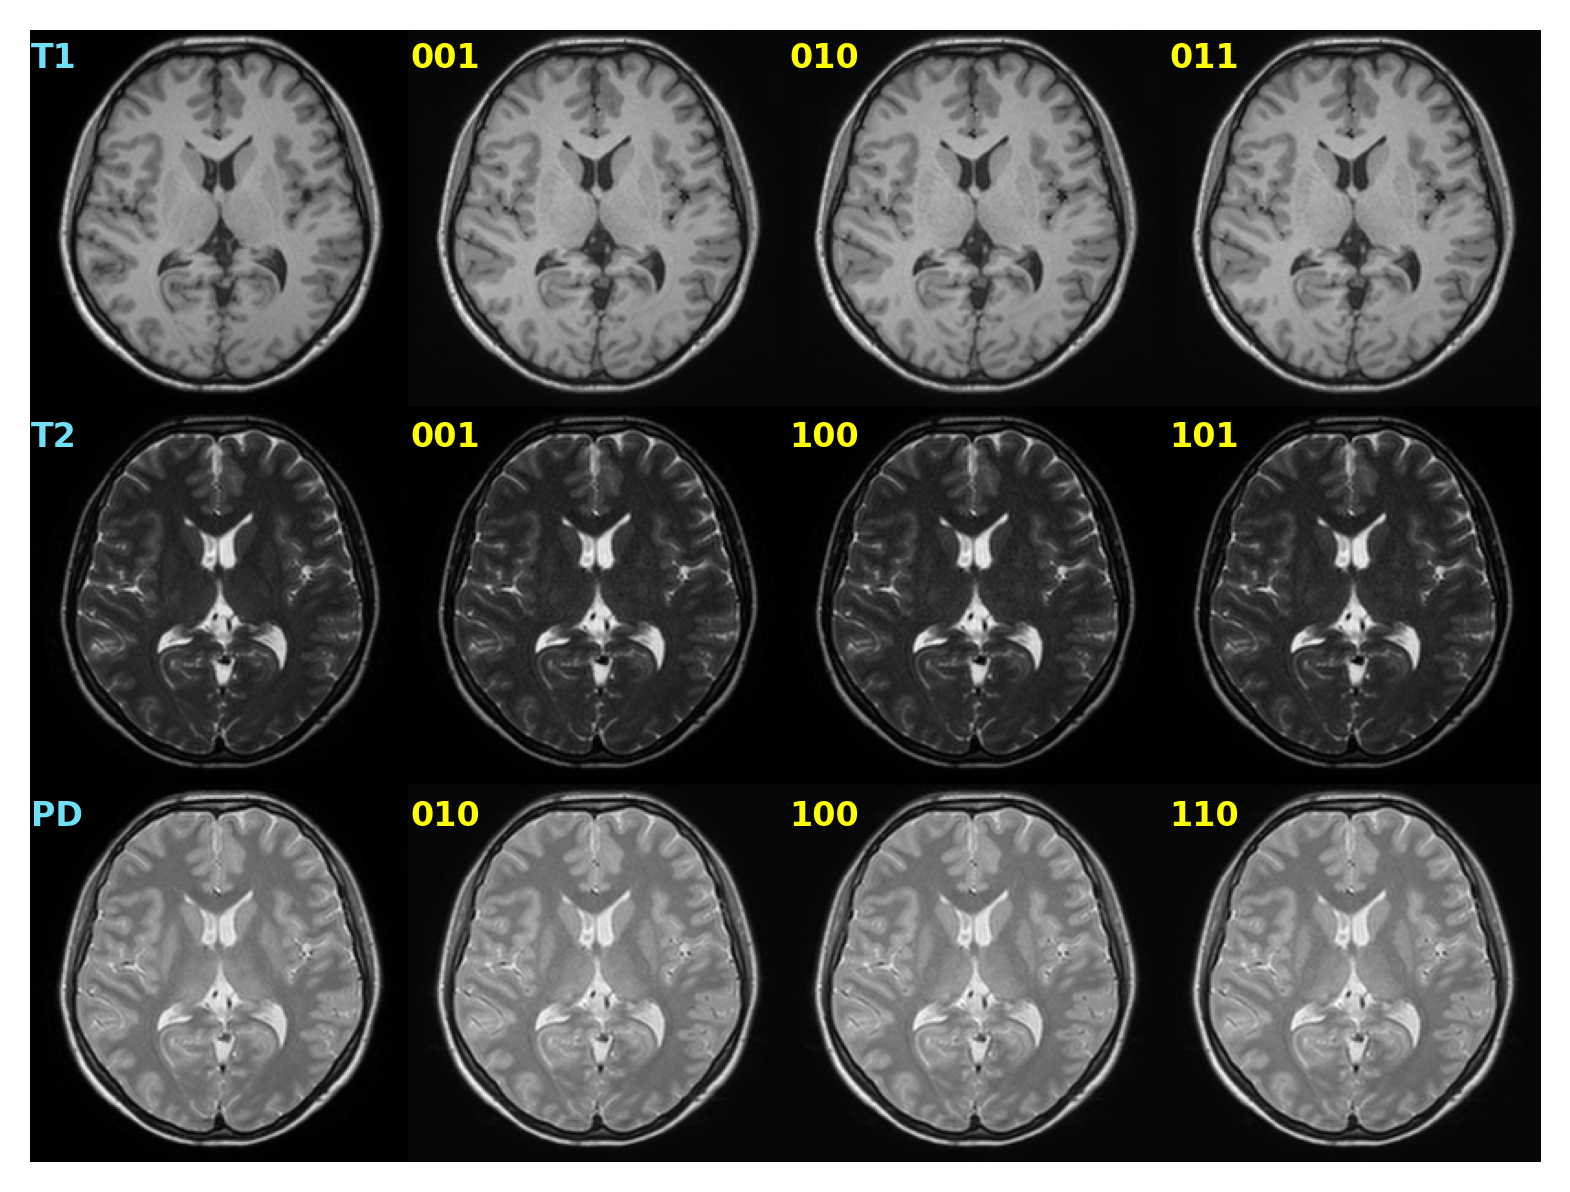

In [3]:
fig, ax = plt.subplots()
ax.imshow(disp_img)

h_offset = 20
nrows = len(cons[method])
ncols = len(get_binary_combs(cons[method][0], method)) + 1
cd = crop_delta[method]
fdict = fontdict=dict(color='yellow', fontsize=8, weight='bold')
for r in np.arange(nrows):
    for c in np.arange(ncols):
        if c == 0:
            fdict['color'] = '#6fe0f7'
        else:
            fdict['color'] = 'yellow'
        txt = txts[r][c]
        t_x = c * (imgY-cd)
        t_y = (r * (imgX-cd)) + h_offset
        ax.text(t_x, t_y, txt, fontdict=fdict)

plt.axis('off')
plt.savefig('/home/srivathsa/projects/mmt_figs/{}_qual_viz_{}_{}.png'.format(method.lower(), case, sl), 
           dpi=350, pad_inches=0.1)

['0001', '0100', '0101', '1000', '1001', '1100', '1101']

### Method Comparison - ZeroGad

<ipython-input-6-e3886905cf02>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0, h_pad=-4, w_pad=0)


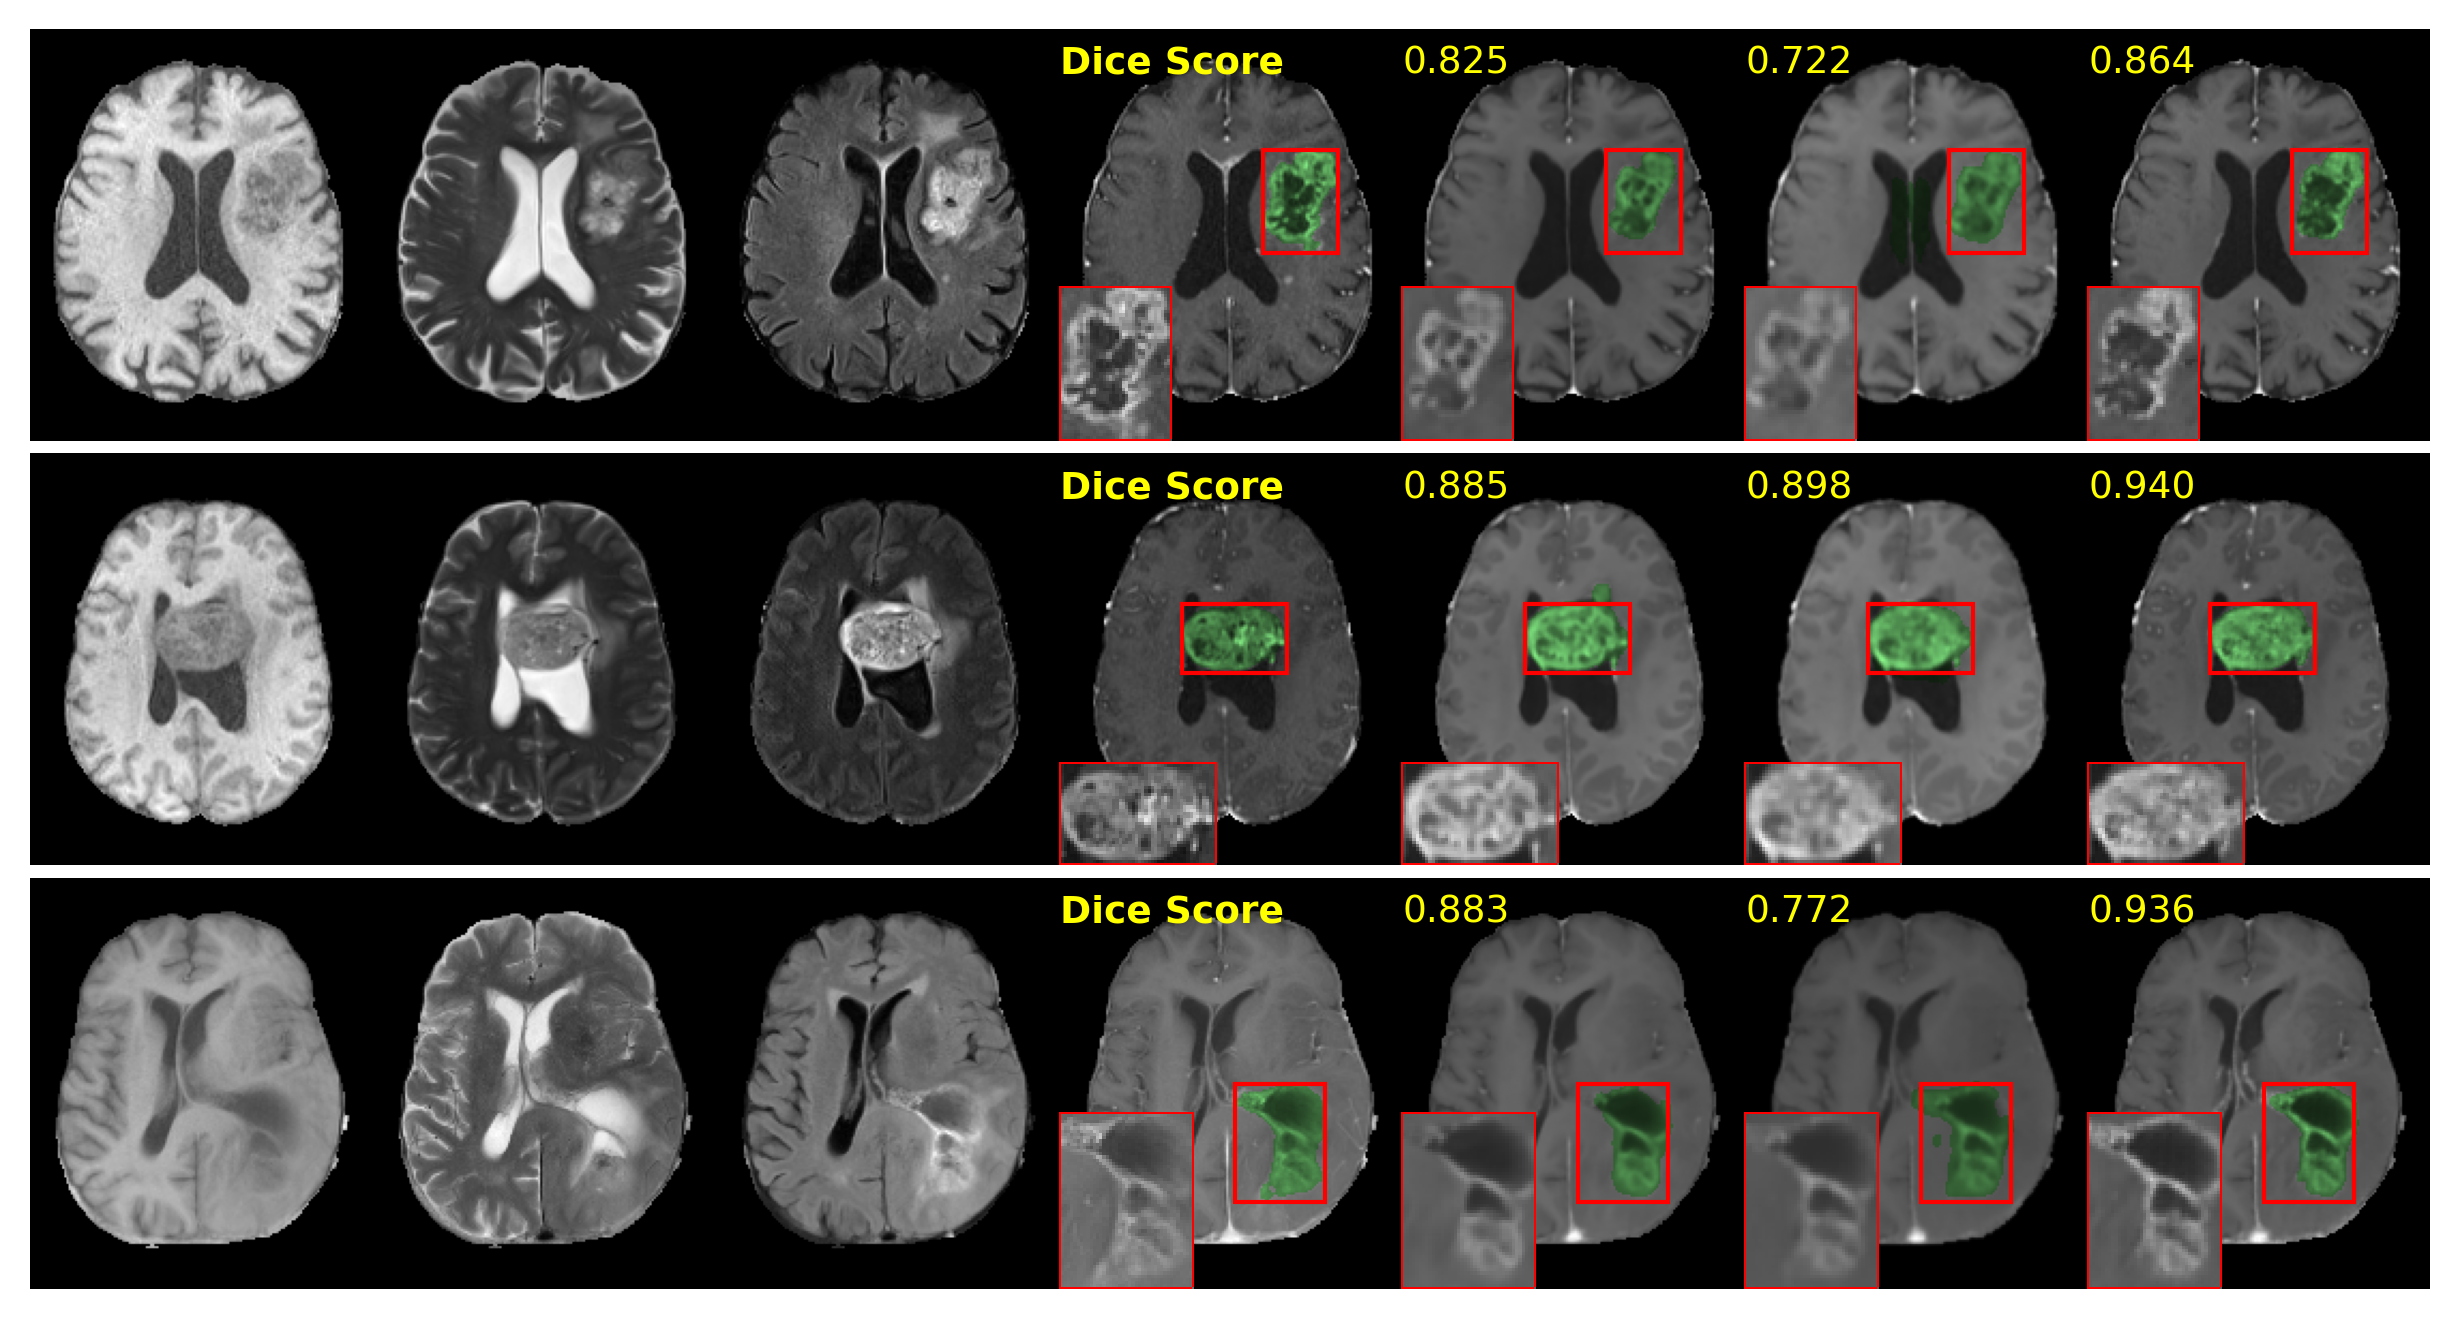

In [6]:
base_path = '/home/srivathsa/projects/mmt_figs/vis_results/BraTS/single'
task_str = '1011'
imgX, imgY = (192, 160)

case_info = [
    ('BraTS2021_00236', 85, (95, 130, 55, 100)), 
    ('BraTS2021_00196', 92, (55, 110, 65, 110)), 
    ('BraTS2021_00807', 85, (95, 130, 55, 100))
]
dpath_label = '/home/srivathsa/projects/studies/gad/mmt_seg/seg/pred'
dpath_dice = '/home/srivathsa/projects/studies/gad/mmt_seg/seg'
fpath_dice = 'T1Gd_syn'
all_imgs = []

dice_metrics = {}

for mth in methods:
    df_csv = pd.read_csv('{}/metrics_{}/{}.csv'.format(dpath_dice, mth.lower(), fpath_dice))
    dice_metrics[mth] = df_csv.to_dict(orient='records')

nrows = len(case_info)
ncols = 7

fig, ax = plt.subplots(nrows, ncols, squeeze=True)

r=0

for case, sl, coords in case_info:
    c=0
    fpaths_png = [fp for fp in glob('{}/*/{}/{}/{:03d}*.png'.format(base_path, task_str, case, sl))]

    fpath_ip = [fp for fp in fpaths_png if 'input' in fp][0]
    fpath_gt = [fp for fp in fpaths_png if 'gt' in fp][0]
    ip_imgs = get_img_chunks(imageio.imread(fpath_ip), imgY)
    for ip_img in ip_imgs:
        ax[r][c].imshow(ip_img)
        ax[r][c].axis('off')
        c += 1
    
    gt_img = imageio.imread(fpath_gt)
    gt_lbl = get_label_slice(dpath_label, fpath_gt, sl=sl)
    y1, y2, x1, x2 = get_tumor_bbox(gt_lbl)
    plot_inset_img(ax[r][c], gt_img, gt_lbl, inset_loc=3, x1=x1, x2=x2, y1=y1, y2=y2)
    ax[r][c].axis('off')
    ax[r][c].text(0, 20, 'Dice Score', color='yellow', weight='bold', fontsize=9)
    c += 1

    fpaths_op = [fp for fp in fpaths_png if 'output' in fp]
    for mth in methods:
        fpath_mth = [fp for fp in fpaths_op if mth in fp][0]
        op_img = imageio.imread(fpath_mth)
        op_lbl = get_label_slice(dpath_label, fpath_mth, sl=sl)
        plot_inset_img(ax[r][c], op_img, op_lbl, inset_loc=3, x1=x1, x2=x2, y1=y1, y2=y2)
        ax[r][c].axis('off')
        dscore = '{:.3f}'.format(get_dice_metric(dice_metrics[mth], case))
        ax[r][c].text(0, 20, dscore, color='yellow', fontsize=9)
        c += 1
    r += 1

fig.tight_layout(pad=0, h_pad=-4, w_pad=0)

### Ablation Study - Figure

<ipython-input-28-8cf871f31bc1>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0, h_pad=0, w_pad=0)


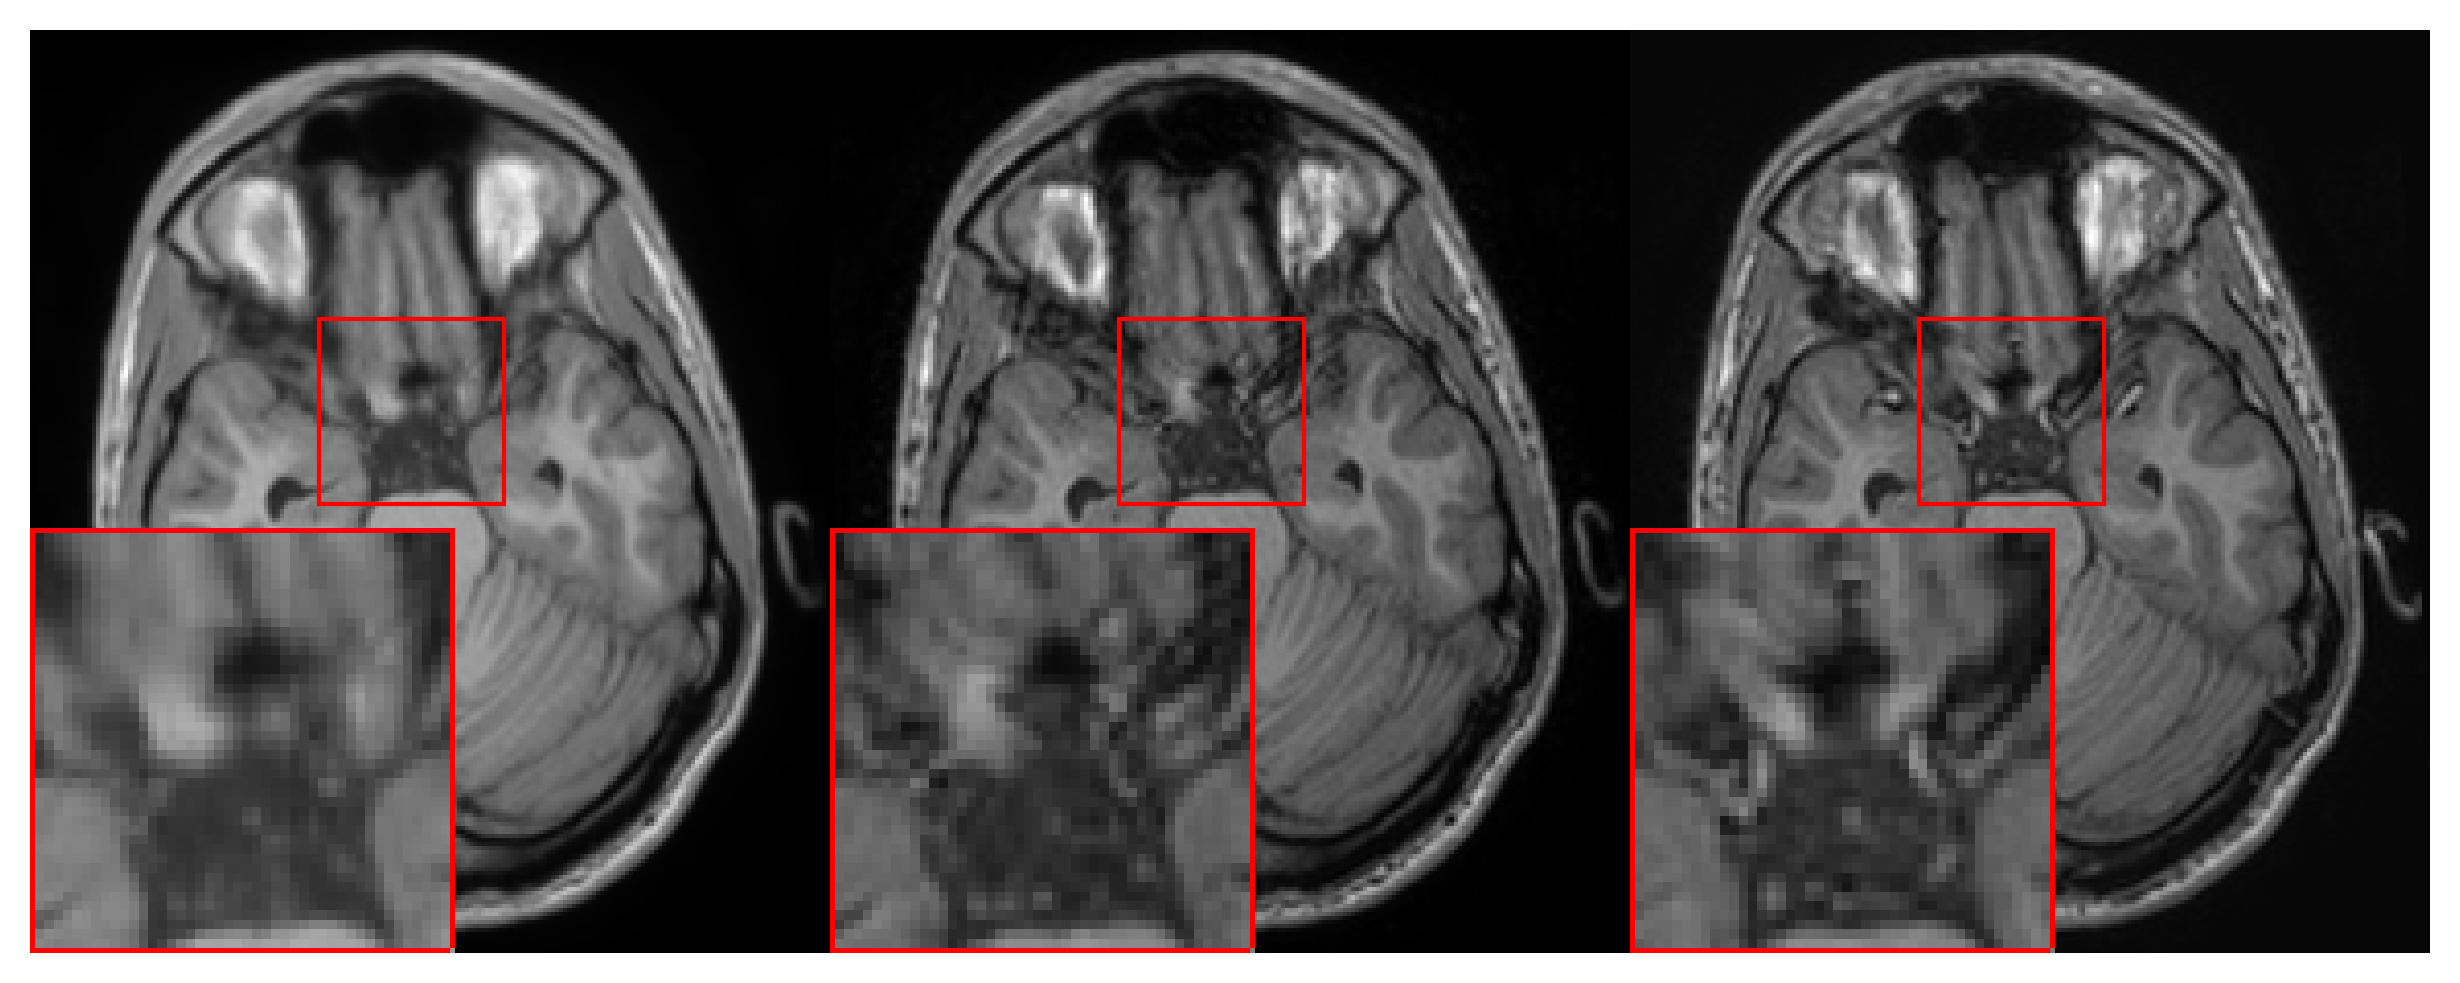

In [28]:
img1 = imageio.imread('/home/srivathsa/projects/mmt_figs/ablation/IXI036-Guys-0736_038_output_ablated.png')
img1 = img1[15:240, 30:225, :-1]

img2 = imageio.imread('/home/srivathsa/projects/mmt_figs/ablation/IXI036-Guys-0736_038_output.png')
img2 = img2[15:240, 30:225, :-1]

img3 = imageio.imread('/home/srivathsa/projects/mmt_figs/ablation/IXI036-Guys-0736_038_gt.png')
img3 = img3[15:240, 30:225, :-1]
fig, ax = plt.subplots(1, 3, squeeze=True)

x1=70
x2=115
y1=70
y2=115
loc=3
zoom=2.3


plot_inset_img(ax[0], img1, label=None, inset_loc=loc, x1=x1, x2=x2, y1=y1, y2=y2, zoom=zoom)
plot_inset_img(ax[1], img2, label=None, inset_loc=loc, x1=x1, x2=x2, y1=y1, y2=y2, zoom=zoom)
plot_inset_img(ax[2], img3, label=None, inset_loc=loc, x1=x1, x2=x2, y1=y1, y2=y2, zoom=zoom)

fig.tight_layout(pad=0, h_pad=0, w_pad=0)